# Frequency Projection

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score,mean_squared_error

from sklearn.datasets import make_classification

import matplotlib.pyplot as plt

import data_cleansing as dc
import data_utils as du

## load the data and apply cleaning steps


In [2]:
data_train_raw, data_test_raw = dc.load_file()

data_test = data_test_raw.copy()
data_train = data_train_raw.copy()


## Setup the dataset 
Set the target

In [3]:

target_cap = 10
data_train['ClaimNb'] = data_train['ClaimNb'].where(data_train['ClaimNb']<target_cap, target_cap)
data_test['ClaimNb'] = data_test['ClaimNb'].where(data_test['ClaimNb']<target_cap, target_cap)

data_train['freq'] = data_train['ClaimNb']/data_train['Exposure']
data_test['freq'] = data_test['ClaimNb']/data_test['Exposure']

target_name='freq'


## Apply lable encoding to the factors

In [4]:

label_encode_factors = ['Area',
                        'VehPower',
                        'VehBrand',
                        'VehGas',
                        'Region',
                        'DrivAgeBand',
                        'DensityBand',
                        'VehAgeBand']
# encode training data and save encoders used
data_train_encoded, encoders = du.preprocess_labelencode(data_train, label_encode_factors)
# apply trained encoders to test set
data_test_encoded = du.preprocess_labelencode_apply(encoders, data_test, label_encode_factors)

## Oversample the minority training data    

** Oversampling the frequency resulted in a good balance between factors, but overstated the overall frequency **

In [5]:
#%% oversample the claim ovservations to create a balanced data set
#data_train_resampled = du.oversample_training_set(data_train_encoded, target_name)
data_train_resampled = data_train_encoded.copy()
print('Before oversampling: \n', data_train_encoded[target_name].value_counts())
print('After  oversampling: \n', data_train_resampled[target_name].value_counts())


Before oversampling: 
 0.000000     371284
1.000000       7561
2.000000       1022
2.040816        354
4.166667        319
              ...  
4.615385          1
33.333333         1
15.789474         1
21.428571         1
6.666667          1
Name: freq, Length: 186, dtype: int64
After  oversampling: 
 0.000000     371284
1.000000       7561
2.000000       1022
2.040816        354
4.166667        319
              ...  
4.615385          1
33.333333         1
15.789474         1
21.428571         1
6.666667          1
Name: freq, Length: 186, dtype: int64


# Setup the Random Forest model

## Split target from factors

In [6]:
#sets used to train (resampled sets)
x_train = data_train_resampled[label_encode_factors].copy()
y_train = data_train_resampled[target_name].copy()

#sets used to predict (and evaluate prediction)
x_train_to_predict = data_train_encoded[label_encode_factors].copy()
y_train_to_predict = data_train_encoded[target_name].copy()
x_test = data_test_encoded[label_encode_factors].copy()
y_test = data_test_encoded[target_name].copy()


## Build the model and predict

In [7]:
%%time
clf_rf = RandomForestRegressor(min_samples_leaf=5, 
                                n_estimators=100,
                                max_depth=50,
                                max_features='auto',
                                criterion='mse',    #mse or mae
                                verbose=True,
                                oob_score=True,
                                n_jobs=3)
#fit values
clf_rf = clf_rf.fit(x_train.values, y_train.values)    

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.3min finished


Wall time: 2min 39s


In [8]:
#predict values
y_train_predicted_rf = clf_rf.predict(x_train_to_predict.values)    
y_test_predicted_rf = clf_rf.predict(x_test.values)  

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    4.7s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   11.2s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    2.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    4.9s finished


## Merge results back to data set

In [9]:
target_name_predicted = target_name + '_predicted'

x_train_to_predict[target_name_predicted] = y_train_predicted_rf
x_train_to_predict[target_name] = y_train_to_predict
x_test[target_name_predicted] = y_test_predicted_rf
x_test[target_name] = y_test

# Test the results 

In [10]:
# total claim results
train_results_actual= x_train_to_predict[target_name].sum()
train_results_predict = x_train_to_predict[target_name_predicted].sum()

test_results_actual= x_test[target_name].sum()
test_results_predict = x_test[target_name_predicted].sum()

test_results_gini = du.gini(x_test[target_name].values, x_test[target_name_predicted].values)
# gini results
train_results_gini = du.gini(x_train_to_predict[target_name].values, x_train_to_predict[target_name_predicted].values)
test_results_gini = du.gini(x_test[target_name].values, x_test[target_name_predicted].values)
# mean squared error
train_results_mse = np.sqrt(mean_squared_error(x_train_to_predict[target_name].values, x_train_to_predict[target_name_predicted].values))
test_results_mse = np.sqrt(mean_squared_error(x_test[target_name].values, x_test[target_name_predicted].values))

print('Total Claims: ', 'Tr Actual {:,.5f}'.format(train_results_actual),
      'Te Actual {:,.5f}'.format(test_results_actual))
print('Total Claims: ', 'Tr Predic {:,.5f}'.format(train_results_predict),
      'Te Predic {:,.5f}'.format(test_results_predict))

print('Results: ',
      'Tr_G {:,.5f}'.format(train_results_gini),
      'Te_G {:,.5f}'.format(test_results_gini),
      'Tr_rmse {:,.5f}'.format(train_results_mse),
      'Te_rmse {:,.5f}'.format(test_results_mse))

print('Factor Importance:\n', pd.DataFrame(zip(clf_rf.feature_importances_, x_train.columns)).sort_values(0, ascending=False))

Total Claims:  Tr Actual 55,207.96994 Te Actual 22,988.82963
Total Claims:  Tr Predic 57,065.20452 Te Predic 25,102.80443
Results:  Tr_G 0.41869 Te_G 0.14782 Tr_rmse 0.70944 Te_rmse 0.76835
Factor Importance:
           0            1
4  0.202108       Region
7  0.199125   VehAgeBand
5  0.137966  DrivAgeBand
1  0.134119     VehPower
2  0.118962     VehBrand
6  0.099611  DensityBand
0  0.059201         Area
3  0.048909       VehGas


### Output the results

In [11]:
data_train_out = data_train_raw.join(x_train_to_predict['freq_predicted'])
data_test_out = data_test_raw.join(x_test['freq_predicted'])

data_train_out.to_pickle('freq_train.pkl')
data_test_out.to_pickle('freq_test.pkl')

print(len(data_test_out), len(data_train_out))

169028 394400


# Review the Results in Charts

## Plot of distribution of results

In [12]:
#%% plot distribution charts
#x_train_to_predict[[target_name, target_name_predicted]].plot(kind='kde', figsize=(20,10))
#x_test[[target_name, target_name_predicted]].plot(kind='kde', figsize=(20,10))


## Plot of mean claim numbers split by factor level

### Plot fit of data

Area
VehPower
VehBrand
VehGas
Region
DrivAgeBand
DensityBand
VehAgeBand
freq_predicted
--target
freq
--target


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


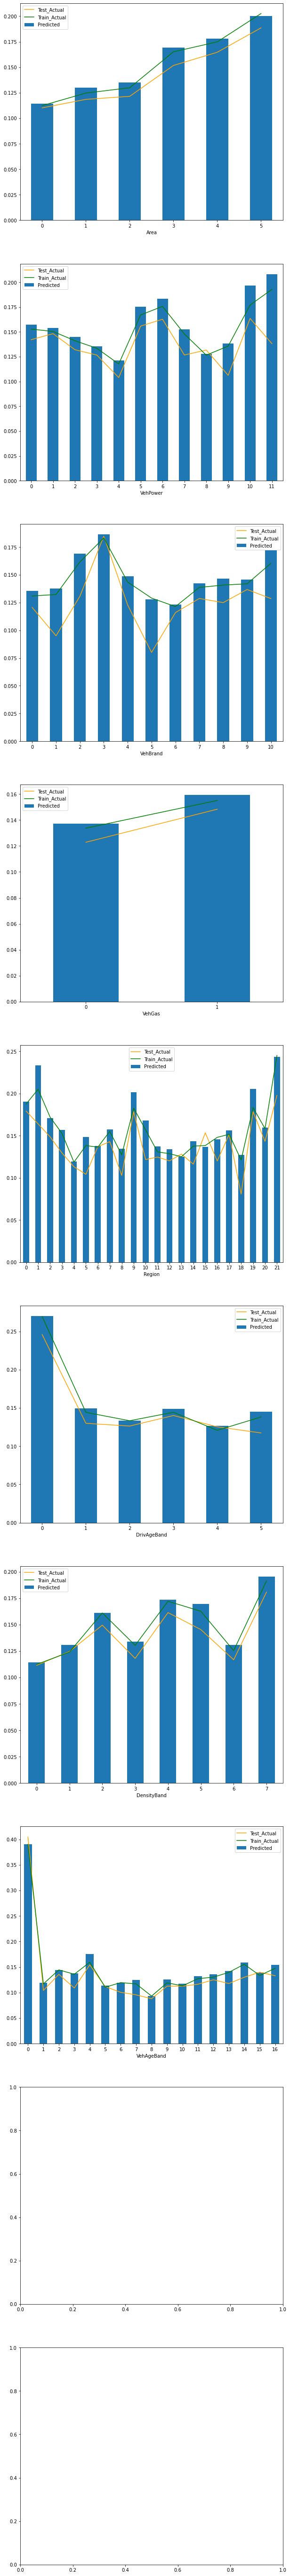

In [13]:
fig = du.plot_factors(x_test, target_name, target_name_predicted, x_train_to_predict)
fig.show()